<a href="https://colab.research.google.com/github/MAI3003-Data-Witches/Data-Witches_Project2/blob/main/MAI3003_DataWitches_Assignment02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Witches**

| **Name**         | **Student ID** |
|------------------|----------------|
| Claessen, VVHJAE | i6339543       |
| Ovsiannikova, AM | i6365923       |
| Pubben, J        | i6276134       |
| Roca Cugat, M    | i6351071       |
| Záboj, J         | i6337952       |

# **Logbook**

**Changes**
Also see Git Commit History.

| **Version** | **Changes**      | **Date** |
|-------------|------------------|----------|
| v0.0        | Dataset loaded, EDA, cleaning   | 18-11-25 |
| v1.1        | *** | XX-11-25 |
| v0.2        | ***  | XX-11-25 |


## Methods

Let's ensure we all use the same names for all components.  

| **Variable**         | **Name**       |
|----------------------|----------------|
| Dataframe (raw)      | df           |
| Encoded dataframe    | df_encoded    |
| Imputed dataframe    | df_imputed    |
| Dataframe unskewed   | df_unskewed   |
| Dataframe normalized | df_normalized |
   

| **Function**              | **Description**                        | **Arguments**                                    |
|---------------------------|----------------------------------------|--------------------------------------------------|
| corr_plot()               | Correlation plot                       | df                                               |
| distplots()               | Distribution plots                     | df                                               |
| drop_high_missing_cols()  | Drop columns with missings             | df, threshold                                    |
| _reconstruct_dataframe()  | Reconstruction function for imputation | encoded_df, original_df, num_cols, cat_cols, enc |
| knn_impute()              | Distribution plots                     | df, min_thresh, max_thresh, n_neighbors          |
| impute_simple_central()   | Distribution plots                     | df, max_thresh                                   |
| normality_check_and_fix() | Distribution plots                     | df                                               |
| skewness_check()          | Distribution plots                     | df                                               |
| model_evaluation()        | Model evaluation                       | model                                            |
| model_desc()              | Model statistics                       | model                                            |


#**Setup: Connect to Kaggle, and download the Physionet 2017 dataset**

In [90]:
!mkdir ~/.kaggle #create the .kaggle folder in your root directory
!echo '{"username":"stefzeemering","key":"5b2e65fcf94d620429eee3e27e514fbe"}' > ~/.kaggle/kaggle.json #write kaggle API credentials to kaggle.json
!chmod 600 ~/.kaggle/kaggle.json  # set permissions
!pip install kaggle #install the kaggle library

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [91]:
!kaggle datasets list -s {'physionet'}

ref                                                        title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
---------------------------------------------------------  --------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
stefzeemering/atrial-fibrillation-classification           Atrial Fibrillation Classification                    50676819  2025-11-11 08:34:23.233000            263          1  0.5882353        
physionet/china-12lead-ecg-challenge-database              China 12-Lead ECG Challenge Database                 425381524  2020-06-15 08:26:52.490000           3190         33  0.875            
physionet/ptbxl-electrocardiography-database               PTB-XL electrocardiography Database                 1452180395  2020-06-15 08:11:55.923000           3918         30  0.875            
physionet/ptb-diagnostic-

In [92]:
# Download the Physionet 20127 dataset from Kaggle
!kaggle datasets download -d {'stefzeemering/atrial-fibrillation-classification'} -p /content/kaggle/ --force


Dataset URL: https://www.kaggle.com/datasets/stefzeemering/atrial-fibrillation-classification
License(s): CC0-1.0
 46% 22.0M/48.3M [00:00<00:00, 222MB/s]
100% 48.3M/48.3M [00:00<00:00, 213MB/s]


In [93]:
import zipfile
zip_ref = zipfile.ZipFile('kaggle/atrial-fibrillation-classification.zip', 'r')
zip_ref.extractall('/content/kaggle')
zip_ref.close()

##**Load the data and extract ECG signals and class labels**

In [94]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")

In [95]:
# load the dataset
df = pd.read_csv('/content/kaggle/Physionet2017TrainingData.csv', header=None, index_col=False)
# convert to mV
df = df / 1000

df_labels = pd.read_csv('/content/kaggle/Physionet2017TrainingLabels.csv',
                    header=None, names=['label'])
df_labels['label'] = df_labels['label'].replace({'N': 'Normal Sinus Rhythm', 'A': 'Atrial Fibrillation'})

#**SPLITTING**

In [96]:
from sklearn.model_selection import train_test_split

# Create binayre AF label
df_labels["af"] = (df_labels["label"] == "Atrial Fibrillation").astype(int)

# Split indices BEFORE preprocessing
train_idx, test_idx = train_test_split(
    df.index,
    test_size=0.2,
    stratify=df_labels["af"],
    random_state=3003
)

print("Train size:", len(train_idx))
print("Test size:", len(test_idx))

Train size: 3619
Test size: 905


# **Characteristics**

In [97]:
# Number of ECGs
num_ecgs = len(df)

# Number of samples per ECG
num_samples = df.shape[1]

# Duration of each ECG
sampling_frequency = 300  # Hz
duration = num_samples / sampling_frequency

# Distribution over classes
class_distribution = df_labels['label'].value_counts()

# Print the summary
print(f"Number of ECGs: {num_ecgs}")
print(f"Number of samples per ECG: {num_samples}")
print(f"Duration of each ECG: {duration} seconds")
print(f"\nClass Distribution:\n{class_distribution}")

Number of ECGs: 4524
Number of samples per ECG: 9000
Duration of each ECG: 30.0 seconds

Class Distribution:
label
Normal Sinus Rhythm    3950
Atrial Fibrillation     574
Name: count, dtype: int64


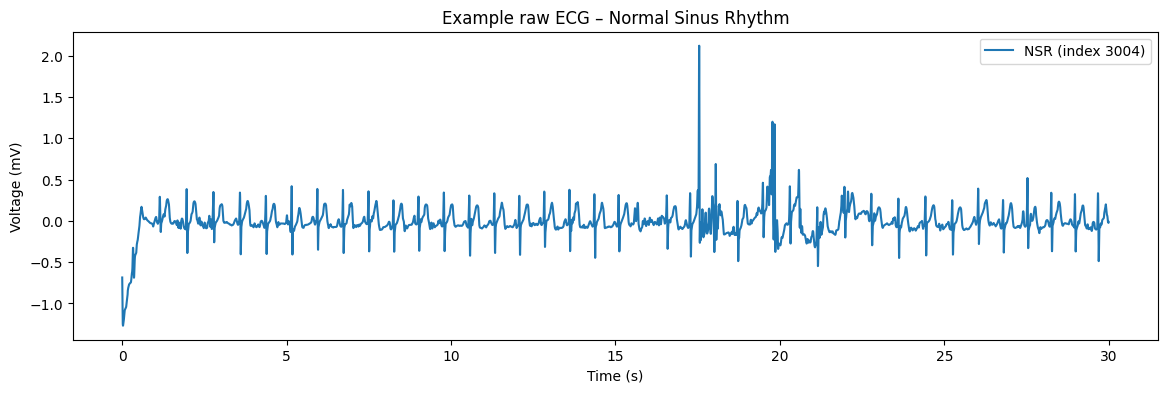

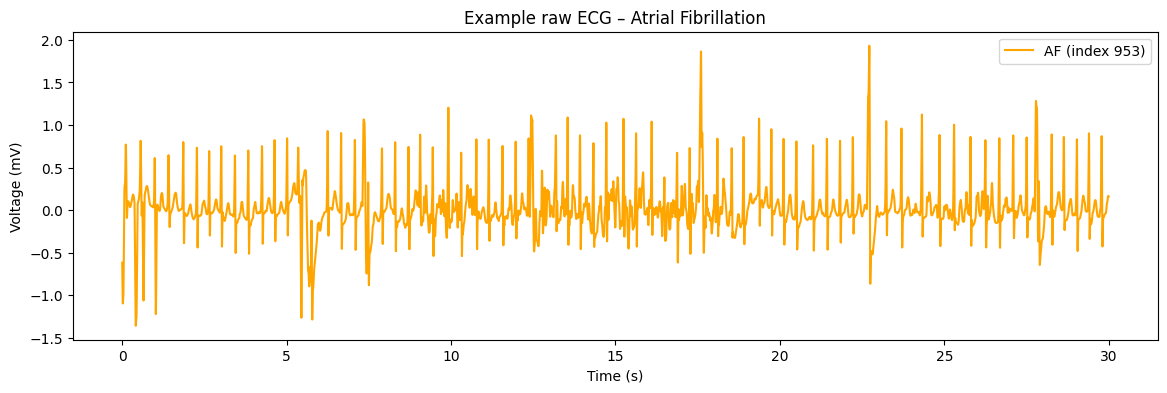

In [98]:
import numpy as np
import matplotlib.pyplot as plt
import random

random.seed(42)

# Indices per class (based on df_labels)
sinus_indices = df_labels[df_labels["label"] == "Normal Sinus Rhythm"].index.tolist()
af_indices    = df_labels[df_labels["label"] == "Atrial Fibrillation"].index.tolist()

example_sinus_idx = random.choice(sinus_indices)
example_af_idx    = random.choice(af_indices)

ecg_sinus_raw = df.iloc[example_sinus_idx].astype(float).values
ecg_af_raw    = df.iloc[example_af_idx].astype(float).values

time = np.arange(0, len(ecg_sinus_raw)) / sampling_frequency

plt.figure(figsize=(14, 4))
plt.plot(time, ecg_sinus_raw, label=f"NSR (index {example_sinus_idx})")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (mV)")
plt.title("Example raw ECG – Normal Sinus Rhythm")
plt.legend()
plt.show()

plt.figure(figsize=(14, 4))
plt.plot(time, ecg_af_raw, label=f"AF (index {example_af_idx})", color="orange")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (mV)")
plt.title("Example raw ECG – Atrial Fibrillation")
plt.legend()
plt.show()

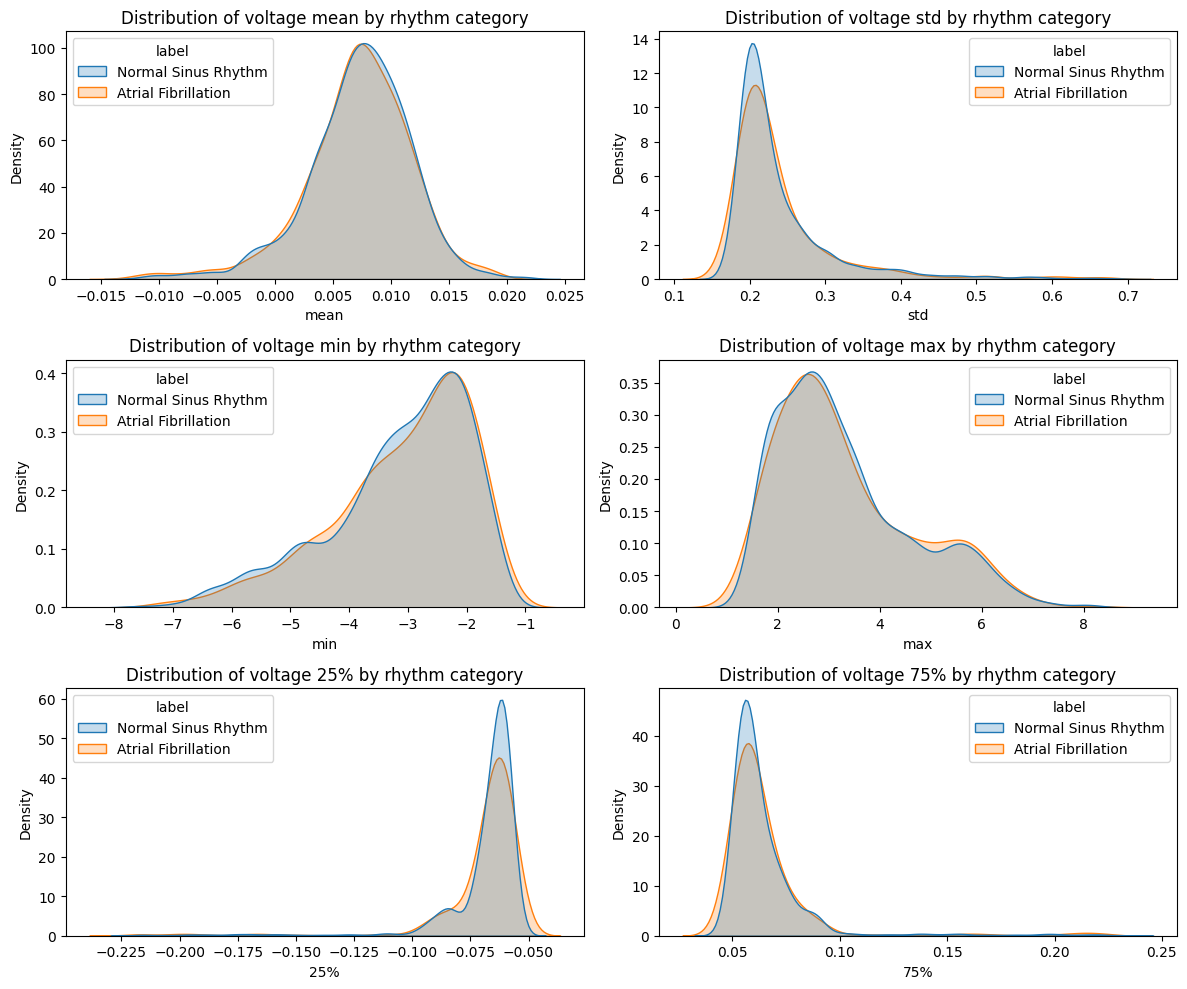

In [99]:
# Summary statistics for each ECG
summary_stats = df.describe().T
summary_stats = pd.concat([summary_stats, df_labels], axis=1)

# Plotting the distributions of summary statistics
stats_to_plot = ['mean', 'std', 'min', 'max', '25%', '75%']

fig, axes = plt.subplots(3, 2, figsize=(12, 10))
axes = axes.flatten()

for i, stat in enumerate(stats_to_plot):
  sns.kdeplot(ax=axes[i], data=summary_stats, x=stat, hue='label', fill=True, common_norm=False)
  axes[i].set_title(f'Distribution of voltage {stat} by rhythm category')
plt.tight_layout()
plt.show()

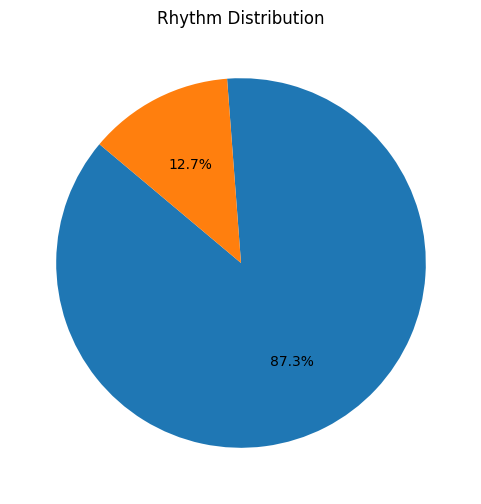

In [100]:
counts = df_labels.label.value_counts().tolist()

plt.figure(figsize=(6, 6))
plt.pie(counts, autopct='%1.1f%%', startangle=140)
plt.title('Rhythm Distribution')
plt.show()

##ECG exploration
Let's have a look at the ECG signals. The AliveCor ECGs are single lead ECGs, similar to **Lead I** in a standard 12-lead ECG. First, we determine which ECGs are in Normal Sinus Rhythm, and which ECGs are in Atrial Fibrillation

In [101]:
# Randomly select ECGs from each class
import random
number_of_selectedECGs = 1  # change to plot more ECGs for each rhythm category
selected_sinus_indices = random.sample(sinus_indices, number_of_selectedECGs)
selected_af_indices = random.sample(af_indices, number_of_selectedECGs)

# Plot each ECG
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create subplots
fig = make_subplots(rows=number_of_selectedECGs, cols=2, subplot_titles=("Normal Sinus Rhythm", "Atrial Fibrillation"))

# Plot NSR ECGs on the left subplot
for i, index in enumerate(selected_sinus_indices):
    time = np.arange(0, len(df.iloc[index])) / sampling_frequency  # Assuming sampling_frequency is defined
    fig.add_trace(go.Scatter(x=time, y=df.iloc[index], mode='lines', name=f'ECG {index + 1}'), row=i+1, col=1)

# Plot AF ECGs on the right subplot
for i, index in enumerate(selected_af_indices):
    time = np.arange(0, len(df.iloc[index])) / sampling_frequency  # Assuming sampling_frequency is defined
    fig.add_trace(go.Scatter(x=time, y=df.iloc[index], mode='lines', name=f'ECG {index + 1}'), row=i+1, col=2)

# Update layout
fig.update_layout(title_text="Selected ECGs: NSR vs. AF",
                  xaxis_title='Time (s)',
                  yaxis_title='Voltage (mV)',
                  showlegend=False,)

fig.show()

## ECG frequency analysis
An important feature of any signal is the frequency content: it tells us which frequency a predominantly present in the signal. In this case, differences in cardiac rhythm may be associated with differences in frequency content. The following code computes the frequency content of an ECG signal using the *Fourier transform* (`fft` in Python).

**Question:** how could we differentiate between NSR and AF based on the frequency content?

In [102]:
# Show the frequency content of each of the selected ECGs
from scipy.fft import fft, fftfreq

# Create subplots
num_ecgs = len(selected_sinus_indices) + len(selected_af_indices)

subplot_titles = []
for index in selected_sinus_indices + selected_af_indices:
    subplot_titles.extend([f"ECG {index+1}", f"FFT {index+1}"])

fig = make_subplots(rows=num_ecgs, cols=2, subplot_titles=subplot_titles)

# Plot selected ECGs and their FFTs
row_num = 1
for index in selected_sinus_indices + selected_af_indices:
    ecg_signal = df.iloc[index].astype(float)
    time = np.arange(0, len(ecg_signal)) / sampling_frequency

    # Calculate FFT
    ecg_data = np.asarray(ecg_signal)
    N = len(ecg_data)
    yf = fft(ecg_data)
    xf = fftfreq(N, 1 / sampling_frequency)
    xf = xf[:N // 2]  # Only consider positive frequencies
    yf = 2.0 / N * np.abs(yf[:N // 2])

    # Plot ECG on the left subplot
    fig.add_trace(go.Scatter(x=time, y=ecg_signal, mode='lines', name=f'ECG {index + 1}'), row=row_num, col=1)

    # Plot FFT on the right subplot
    fig.add_trace(go.Scatter(x=xf, y=yf, mode='lines', name=f'FFT {index + 1}'), row=row_num, col=2)

    row_num += 1

# Update layout
fig.update_layout(title_text="Selected ECGs and FFTs",
                  xaxis_title='Time (s)',
                  xaxis2_title='Frequency (Hz)',
                  yaxis_title='Amplitude',
                  yaxis2_title='Magnitude',
                  showlegend=False,
                  height=num_ecgs * 300)  # Adjust height based on the number of ECGs

fig.show()

The *Welch periodogram* is an approach to estimate the frequency content of a signal that computes the *average* spectrogram of overlapping signal segments.

In [103]:
# Compute the Welch periodogram instead of the fft

from scipy.signal import welch

# Show the frequency content of each of the selected ECGs using Welch's method

# Create subplots
num_ecgs = len(selected_sinus_indices) + len(selected_af_indices)

subplot_titles = []
for index in selected_sinus_indices + selected_af_indices:
    subplot_titles.extend([f"ECG {index+1}", f"Welch Periodogram {index+1}"])

fig = make_subplots(rows=num_ecgs, cols=2, subplot_titles=subplot_titles)

# Plot selected ECGs and their Welch periodograms
numberOfSamplesPerFFT=1024
row_num = 1
for index in selected_sinus_indices + selected_af_indices:
    ecg_signal = df.iloc[index].astype(float)
    time = np.arange(0, len(ecg_signal)) / sampling_frequency

    # Calculate Welch periodogram
    ecg_data = np.asarray(ecg_signal) # Convert pandas Series to NumPy array
    frequencies, power_spectrum = welch(ecg_data, fs=sampling_frequency, nperseg=numberOfSamplesPerFFT)

    # Plot ECG on the left subplot
    fig.add_trace(go.Scatter(x=time, y=ecg_signal, mode='lines', name=f'ECG {index + 1}'), row=row_num, col=1)

    # Plot Welch periodogram on the right subplot
    fig.add_trace(go.Scatter(x=frequencies, y=power_spectrum, mode='lines', name=f'Welch {index + 1}'), row=row_num, col=2)

    row_num += 1

# Update layout
fig.update_layout(title_text="Selected ECGs and Welch Periodograms",
                  xaxis_title='Time (s)',
                  xaxis2_title='Frequency (Hz)',
                  yaxis_title='Amplitude',
                  yaxis2_title='Power Spectral Density',
                  showlegend=False,
                  height=num_ecgs * 300)  # Adjust height based on the number of ECGs

fig.show()

##ECG Pre-processing
When dealing with real-world signals, it is important to evaluate the quality of the data and consider implementing filter approaches to reduce the presence of measurement noise or artifacts in your data. Common sources of noise are:
- Powerline interference: sinusoidal signals with a frequency of 50 or 60Hz originating from other (poorly insulated) devices
- Muscle noise: Electrical interference caused by the patient's tensed muscles.
- Motion artifacts: caused by body movements or talking.
- Poor electrode contact: improper electrode placement or quality
- Baseline wander: varying baseline level (iso-electric line), for instance caused by breathing

Let's look at a few examples of how these filters work. We will use the neurokit2 package to simulate ECGs and then design and apply several filters

In [104]:
# We use the neurokit package to simulate ECG signals
#Install neurokit2 if needed
!pip install neurokit2
import neurokit2 as nk

### Powerline interference

In [105]:
# simulate an ECG
ecg_sim = nk.ecg_simulate(duration=5, sampling_rate = sampling_frequency, method="ecgsyn")
time = np.arange(0, len(ecg_sim)) / sampling_frequency

# Add a 50Hz signal
frequency = 50  # Hz
amplitude = 0.1  # Adjust the amplitude as needed
signal_50hz = amplitude * np.sin(2 * np.pi * frequency * time)

# Add the 50Hz signal to ecg_sim
ecg_sim_with_50hz = ecg_sim + signal_50hz

# Plot both signals
fig = go.Figure()
fig.add_trace(go.Scatter(x=time, y=ecg_sim_with_50hz, mode='lines', name='ECG with 50Hz Noise'))
fig.add_trace(go.Scatter(x=time, y=ecg_sim, mode='lines', name='Original ECG'))
fig.update_layout(title_text="ECG Signals: Original vs. with 50Hz Noise",
                  xaxis_title="Time (s)",
                  yaxis_title="Amplitude")
fig.show()

In [106]:
# Compute and show the Welch periodogram of the 50Hz ecg signal
frequencies, power_spectrum = welch(ecg_sim_with_50hz, fs=sampling_frequency, nperseg=1024)

fig = go.Figure()
fig.add_trace(go.Scatter(x=frequencies, y=power_spectrum, mode='lines', name='Welch Periodogram'))
fig.update_layout(title_text="Welch Periodogram of 50Hz ECG Signal",
                  xaxis_title="Frequency (Hz)",
                  yaxis_title="Power Spectral Density")
fig.show()

Now we create a so-called *notch filter*: this is a filter that supresses a certain frequency in a signal, in this case 50Hz

In [107]:
# Standard signal processing algorithm can be found in the package scipy.signal
import scipy.signal as signal

# filter design
notch_freq = 50 # frequency that we want to filter out
quality_factor = 30
nyquist_freq = 0.5 * sampling_frequency
normalized_notch_freq = notch_freq / nyquist_freq
b, a = signal.iirnotch(normalized_notch_freq, quality_factor)

# apply the filter to the signal with noise
filtered_ecg = signal.filtfilt(b, a, ecg_sim_with_50hz)

# Plot the original signal with noise and filtered signal
fig = go.Figure()
fig.add_trace(go.Scatter(x=time, y=ecg_sim_with_50hz, mode='lines', name='ECG with 50Hz Noise'))
fig.add_trace(go.Scatter(x=time, y=ecg_sim, mode='lines', name='Original ECG'))
fig.add_trace(go.Scatter(x=time, y=filtered_ecg, mode='lines', name='Filtered ECG'))

fig.update_layout(title_text="ECG Signals: with 50Hz Noise vs. Filtered",
                  xaxis_title="Time (s)",
                  yaxis_title="Amplitude")
fig.show()

###Baseline wander

In [108]:
# Simulate an ECG
sampling_frequency = 300  # Hz
ecg_sim = nk.ecg_simulate(duration=10, sampling_rate=sampling_frequency, method="ecgsyn")
time = np.arange(0, len(ecg_sim)) / sampling_frequency

# Add baseline wander
wander = 0.5 * np.sin(2 * np.pi * 0.3 * time)  # 0.3 Hz baseline wander
ecg_wander = ecg_sim + wander

fig = go.Figure()
fig.add_trace(go.Scatter(x=time, y=ecg_wander, mode='lines', name='ECG with Wander'))
fig.add_trace(go.Scatter(x=time, y=ecg_sim, mode='lines', name='Original ECG'))
fig.update_layout(title_text="ECG Signals: Baseline Wandering",
                  xaxis_title="Time (s)",
                  yaxis_title="Amplitude")

In [109]:
# Compute and show the Welch periodogram of the baseline wander ecg signal
frequencies, power_spectrum = welch(ecg_wander, fs=sampling_frequency, nperseg=1024)

fig = go.Figure()
fig.add_trace(go.Scatter(x=frequencies, y=power_spectrum, mode='lines', name='Welch Periodogram'))
fig.update_layout(title_text="Welch Periodogram of baseline wander ECG Signal",
                  xaxis_title="Frequency (Hz)",
                  yaxis_title="Power Spectral Density")
fig.show()

In [110]:
# Apply a median filter
window_size = 101  # Adjust window size as needed
ecg_median_filtered = ecg_wander - signal.medfilt(ecg_wander, kernel_size=window_size)

# Apply a 0.5Hz high-pass filter
cutoff_freq = 0.5  # Hz
nyquist_freq = 0.5 * sampling_frequency
normalized_cutoff = cutoff_freq / nyquist_freq
b, a = signal.butter(4, normalized_cutoff, btype='high', analog=False)
ecg_highpass_filtered = signal.filtfilt(b, a, ecg_wander)

# Plot the results
fig = go.Figure()
fig.add_trace(go.Scatter(x=time, y=ecg_wander, mode='lines', name='ECG with Wander'))
fig.add_trace(go.Scatter(x=time, y=ecg_sim, mode='lines', name='Original ECG'))
fig.add_trace(go.Scatter(x=time, y=ecg_median_filtered, mode='lines', name='ECG Median Filtered'))
fig.add_trace(go.Scatter(x=time, y=ecg_highpass_filtered, mode='lines', name='ECG High-pass Filtered'))

fig.update_layout(title_text="ECG Signals: Baseline Wander Removal Comparison",
                  xaxis_title="Time (s)",
                  yaxis_title="Amplitude")
fig.show()

###Muscle noise

In [111]:
# Generate EMG noise at random intervals
emg_noise = np.zeros_like(ecg_sim)

std_dev_emg_noise = 0.05
duration_emg_noise = int(0.05 * sampling_frequency)

for _ in range(10 * 20):  # Assuming an average of 20 contractions per second
    start = np.random.randint(0, len(ecg_sim) - duration_emg_noise)
    emg_noise[start:start + duration_emg_noise] += np.random.normal(0, std_dev_emg_noise, duration_emg_noise)

# Combine ECG signal with EMG noise
ecg_muscle = ecg_sim + emg_noise

fig = go.Figure()
fig.add_trace(go.Scatter(x=time, y=ecg_sim, mode='lines', name='Original ECG'))
fig.add_trace(go.Scatter(x=time, y=ecg_muscle, mode='lines', name='ECG with Muscle Noise'))
fig.update_layout(title_text="ECG Signals: Muscle Noise",
                  xaxis_title="Time (s)",
                  yaxis_title="Amplitude")

In [112]:
# Apply a 100Hz low-pass filter
cutoff_freq = 100  # Hz
nyquist_freq = 0.5 * sampling_frequency
normalized_cutoff = cutoff_freq / nyquist_freq
b, a = signal.butter(4, normalized_cutoff, btype='low', analog=False)
ecg_lowpass_filtered = signal.filtfilt(b, a, ecg_sim)

# Plot the original signal with noise and filtered signal
fig = go.Figure()
fig.add_trace(go.Scatter(x=time, y=ecg_muscle, mode='lines', name='ECG with Muscle Noise'))
fig.add_trace(go.Scatter(x=time, y=ecg_lowpass_filtered, mode='lines', name='ECG Low-pass Filtered'))
fig.add_trace(go.Scatter(x=time, y=ecg_sim, mode='lines', name='Original ECG',
                         line=dict(color='gray', width=1.5)))
fig.update_layout(title_text="ECG Signals: with Muscle Noise vs. Filtered",
                  xaxis_title="Time (s)",
                  yaxis_title="Amplitude")
fig.show()

##ECG feature engineering

Tradionally, ECG analysis is done visually, with a cardiologist/electrophysiologist that assesses the ECG signal(s) and makes a diagnosis based on standardized criteria (for instance the [Minnesota Code](https://link.springer.com/book/10.1007/978-1-84882-778-3)). Conventional ECG analysis tool translate these criteria into a set of automated algorithms that extract features that can then be used to classify the rhythm on an ECG. Standard criteria to diagnose AF from an ECG are:
- Required
  - Absence of a visible P-wave
  - Irregularly irregular heart rhythm
- Optional
  - Presence of f-waves / absence of isoelectric baseline
  - Fast ventricular rate

In this workshop we will focuse on crafting features related to heart rate variability, as the visibility of the P-wave is often limited in lead I, due to its low amplitude.

###Feature extraction using NeuroKit

NeuroKit can be used to process ECG and compute features related to *heart rate variability* (HRV). See https://doi.org/10.3390/s21123998 for an overview of HRV features.

The package computes features in 3 domains:
- *time domain*: features based on variability in the heart rate intervals (R-R intervals)
- *frequency domain*: frequency content of the R-R interval series, reflecting parasympathetic and sympathetic activity
- *nonlinear dynamics*: features that try to capture the underlying dynamics of the R-R series. The Poincare plot is a well-known example of a nonlinear analysis.

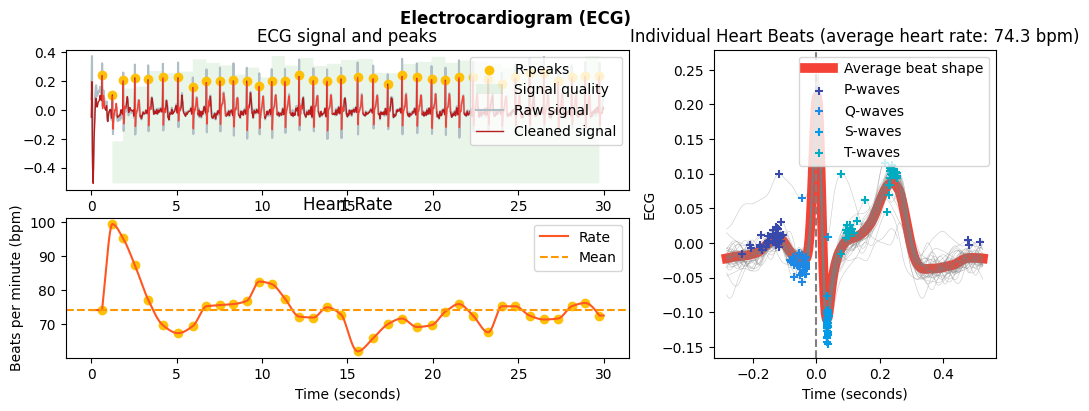

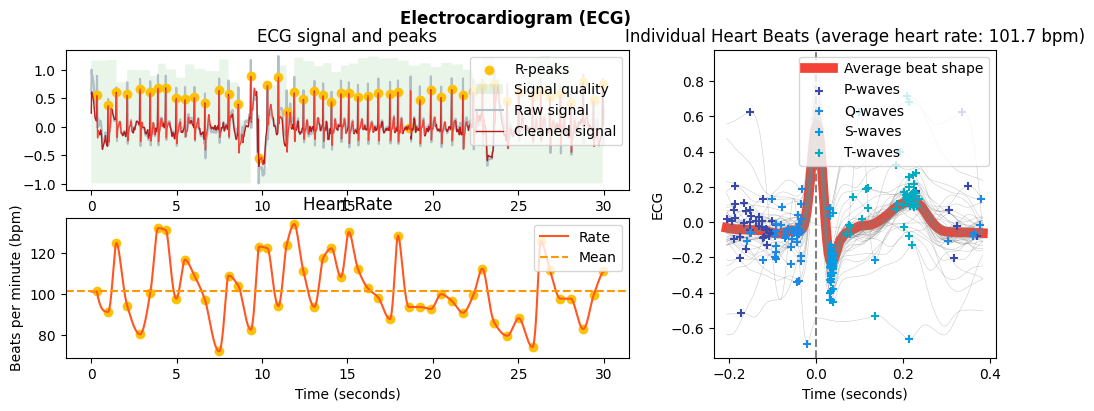

In [113]:
# Select an ECG in Normal Sinus Rhythm and one in AF and process them
selected_sinus_indices = random.sample(sinus_indices, 1)
selected_af_indices = random.sample(af_indices, 1)

ecg_NSR = df.iloc[selected_sinus_indices[0]].astype(float)
signals_NSR, info_NSR = nk.ecg_process(ecg_NSR, sampling_rate=sampling_frequency)

# Visualise the processing
plt.rcParams['figure.figsize'] = [12, 4]
nk.ecg_plot(signals_NSR, info_NSR)

ecg_AF = df.iloc[selected_af_indices[0]].astype(float)
signals_AF, info_AF = nk.ecg_process(ecg_AF, sampling_rate=sampling_frequency)

# Visualise the processing
nk.ecg_plot(signals_AF, info_AF)

####**R-peaks**

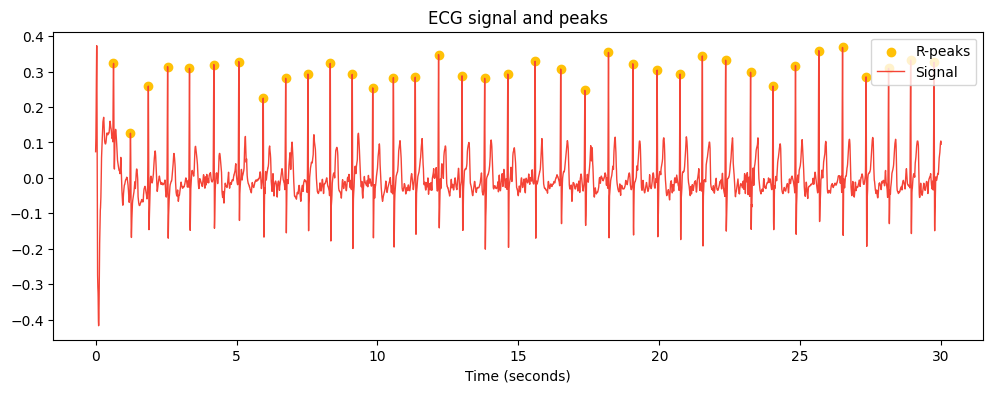

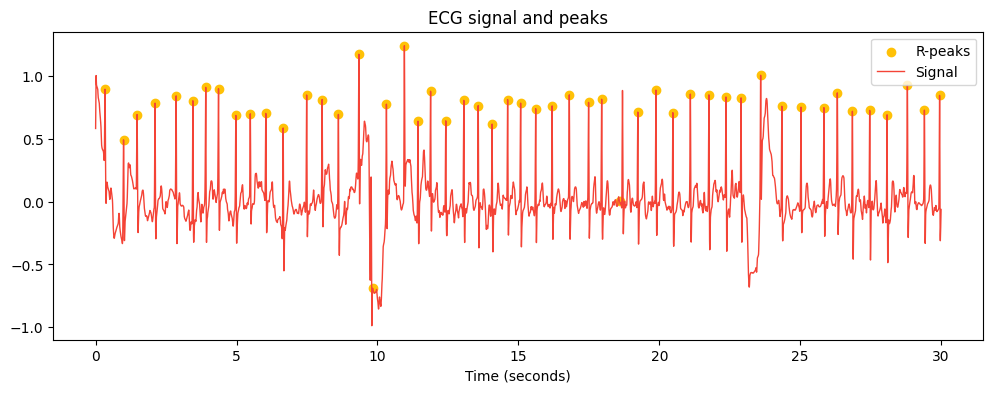

In [114]:
# Find R-peaks
peaks_NSR, info_NSR = nk.ecg_peaks(ecg_NSR, sampling_rate=sampling_frequency, correct_artifacts=True, show=True)
peaks_AF, info_AF = nk.ecg_peaks(ecg_AF, sampling_rate=sampling_frequency, correct_artifacts=True, show=True)

#### **Time-domain features**

HRV_MeanNN   HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  808.703704  70.252505         NaN         NaN         NaN         NaN   

   HRV_SDANN5  HRV_SDNNI5  HRV_RMSSD   HRV_SDSD  HRV_CVNN  HRV_CVSD  \
0         NaN         NaN  49.009231  49.288684  0.086871  0.060602   

   HRV_MedianNN  HRV_MadNN  HRV_MCVNN  HRV_IQRNN  HRV_SDRMSSD  HRV_Prc20NN  \
0         815.0     42.007   0.051542  55.833333     1.433455        780.0   

   HRV_Prc80NN  HRV_pNN50  HRV_pNN20   HRV_MinNN  HRV_MaxNN  HRV_HTI  HRV_TINN  
0   863.333333       25.0  58.333333  603.333333      970.0      6.0  195.3125

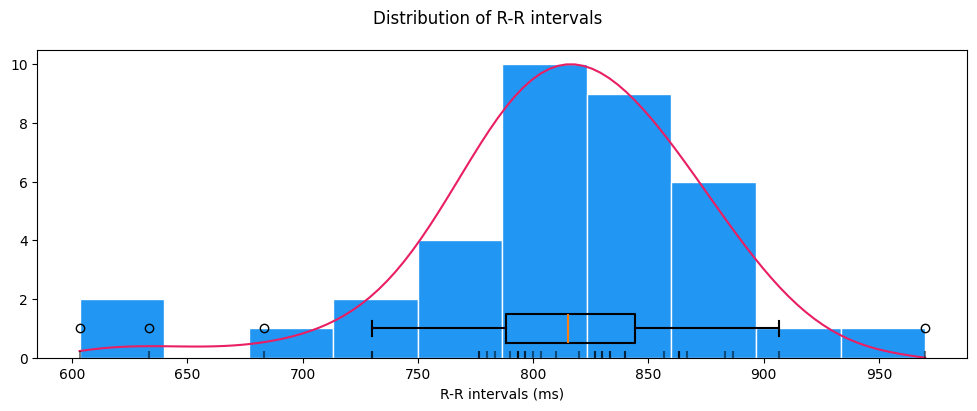

In [115]:
# Time domain features NSR
hrv_time_NSR = nk.hrv_time(peaks_NSR, sampling_rate=sampling_frequency, show=True)
hrv_time_NSR

HRV_MeanNN  HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0       592.2  94.81958         NaN         NaN         NaN         NaN   

   HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD    HRV_SDSD  HRV_CVNN  HRV_CVSD  \
0         NaN         NaN  124.880896  126.152098  0.160114  0.210876   

   HRV_MedianNN  HRV_MadNN  HRV_MCVNN   HRV_IQRNN  HRV_SDRMSSD  HRV_Prc20NN  \
0    601.666667     93.898   0.156063  126.666667      0.75928   492.666667   

   HRV_Prc80NN  HRV_pNN50  HRV_pNN20   HRV_MinNN   HRV_MaxNN  HRV_HTI  \
0   657.333333       70.0       84.0  446.666667  833.333333     10.0   

   HRV_TINN  
0  164.0625

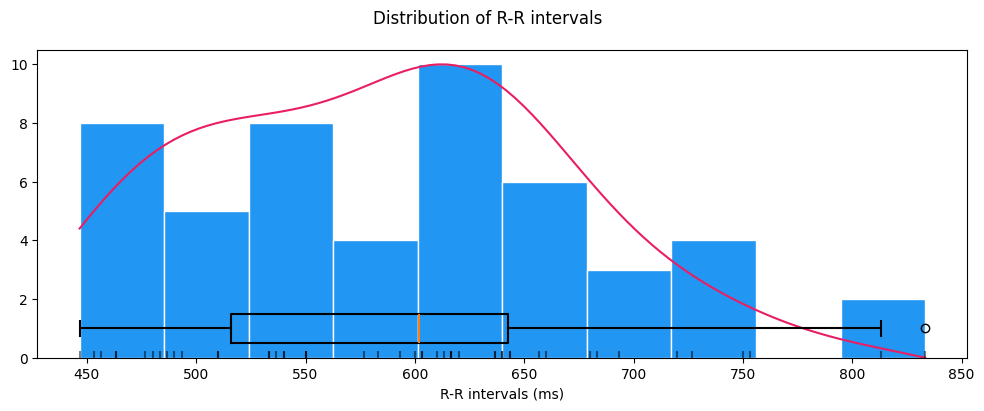

In [116]:
# Time domain features AF
hrv_time_AF = nk.hrv_time(peaks_AF, sampling_rate=sampling_frequency, show=True)
hrv_time_AF

###**HRV time-domain feature extraction for all ECGs**

In [117]:
from tqdm import tqdm

# Create an empty list to store the HRV features
hrv_features_train = []

# Loop through TRAIN ECGs and extract HRV features
for i in tqdm(train_idx, desc="HRV: TRAIN SET"):
    ecg = df.iloc[i].astype(float)
    try:
        # Clean the ECG first
        ecg_clean = nk.ecg_clean(ecg, sampling_rate=sampling_frequency)
        # Find R-peaks
        peaks, _ = nk.ecg_peaks(ecg_clean, sampling_rate=sampling_frequency)

        # Extract time-domain HRV features
        hrv_time = nk.hrv_time(peaks, sampling_rate=sampling_frequency)

        # Convert hrv_time to a Series and add ECG index
        hrv_time_series = hrv_time.squeeze()  # Convert DataFrame to Series
        hrv_time_series['ecg_index'] = i

        # Add the HRV features to the list
        hrv_features_train.append(hrv_time_series)

    except Exception as e:
        print(f"Error processing ECG {i}: {e}")
        # Handle the error by appending a DataFrame with NaN values for HRV features
        # Create a DataFrame with NaN values and the correct columns
        if hrv_features_train:
          empty_hrv_time = pd.DataFrame(
              [[float('nan')] * len(hrv_features_train[0].index)],  # Get length of index from the first element if it exists
              columns=hrv_features_train[0].index, # Handle empty list, use index as columns
              index=[0] # add dummy index
              ).squeeze() # convert to series
          empty_hrv_time['ecg_index'] = i # add ecg index
          hrv_features_train.append(empty_hrv_time)

# Create a dataframe from the list of HRV features
hrv_train = pd.DataFrame(hrv_features_train)

HRV: TRAIN SET: 100%|██████████| 3619/3619 [01:58<00:00, 30.53it/s]


In [118]:
# Examine the output
hrv_train.head()

HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  523.696970   99.266181         NaN         NaN         NaN         NaN   
0  803.148148   53.004609         NaN         NaN         NaN         NaN   
0  772.342342   22.809800         NaN         NaN         NaN         NaN   
0  749.385965  195.850122         NaN         NaN         NaN         NaN   
0  875.252525   96.007198         NaN         NaN         NaN         NaN   

   HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD    HRV_SDSD  HRV_CVNN  HRV_CVSD  \
0         NaN         NaN  143.569286  144.910298  0.189549  0.274146   
0         NaN         NaN   18.567765   18.306958  0.065996  0.023119   
0         NaN         NaN   18.625616   18.888889  0.029533  0.024116   
0         NaN         NaN  296.190021  300.261370  0.261347  0.395244   
0         NaN         NaN  152.857050  155.205379  0.109691  0.174643   

   HRV_MedianNN  HRV_MadNN  HRV_MCVNN   HRV_IQRNN  HRV_SDRMSSD  HRV_Prc20NN  \
0    490.000000     64.246   0.131114   93.333333     0.691417   446.666667   
0    816.666667     51.891   0.063540   85.000000     2.854657   743.333333   
0    773.333333     19.768   0.025562   26.666667     1.224647   760.666667   
0    776.666667    168.028   0.216345  262.500000     0.661231   567.333333   
0    853.333333     54.362   0.063705   73.333333     0.628085   828.000000   

   HRV_Prc80NN  HRV_pNN50  HRV_pNN20   HRV_MinNN    HRV_MaxNN    HRV_HTI  \
0   570.000000  56.363636  80.000000  410.000000   823.333333   9.166667   
0   850.000000   0.000000  22.222222  696.666667   886.666667   7.200000   
0   792.666667   0.000000  27.027027  710.000000   810.000000   3.700000   
0   868.000000  81.578947  94.736842  443.333333  1393.333333  12.666667   
0   930.666667  75.757576  87.878788  660.000000  1083.333333  11.000000   

   HRV_TINN  ecg_index  
0   54.6875     4159.0  
0   93.7500     1521.0  
0   85.9375     1880.0  
0  390.6250     2332.0  
0  234.3750     2326.0

In [119]:
# Remove all columns from the dataframe that contain more than 50% NaN
threshold = 0.5
hrv_train_clean = hrv_train.dropna(thresh=len(hrv_train) * threshold, axis=1)

# Remove all rows that are all NaN
hrv_df_clean = hrv_df_clean.dropna(how='all')

hrv_df_clean.head()

HRV_MeanNN   HRV_SDNN   HRV_RMSSD    HRV_SDSD  HRV_CVNN  HRV_CVSD  \
0  1031.666667  89.601312  109.045617  110.874677  0.086851  0.105698   
0   715.121951  37.134123   15.383974   15.576299  0.051927  0.021512   
0   820.476190  15.427309   13.023358   13.173808  0.018803  0.015873   
0   647.851852  41.115479   21.021874   21.237828  0.063464  0.032449   
0  1093.461538  92.925207  141.594099  144.512847  0.084983  0.129492   

   HRV_MedianNN  HRV_MadNN  HRV_MCVNN   HRV_IQRNN  HRV_SDRMSSD  HRV_Prc20NN  \
0   1010.000000     51.891   0.051377   73.333333     0.821687   986.000000   
0    706.666667     29.652   0.041960   36.666667     2.413819   683.333333   
0    823.333333     19.768   0.024010   20.000000     1.184588   809.333333   
0    640.000000     39.536   0.061775   46.666667     1.955843   613.333333   
0   1101.666667     71.659   0.065046  110.000000     0.656279  1003.333333   

   HRV_Prc80NN  HRV_pNN50  HRV_pNN20   HRV_MinNN    HRV_MaxNN   HRV_HTI  \
0  1075.333333  39.285714  71.428571  793.333333  1276.666667  7.000000   
0   743.333333   2.439024   4.878049  676.666667   803.333333  3.727273   
0   836.666667   0.000000  14.285714  790.000000   850.000000  3.888889   
0   683.333333   4.444444  15.555556  580.000000   773.333333  6.428571   
0  1150.000000  65.384615  84.615385  956.666667  1400.000000  6.500000   

   HRV_TINN  ecg_index  
0  226.5625        0.0  
0    0.0000        1.0  
0   31.2500        2.0  
0   54.6875        3.0  
0  164.0625        4.0

###**Feature exploration**

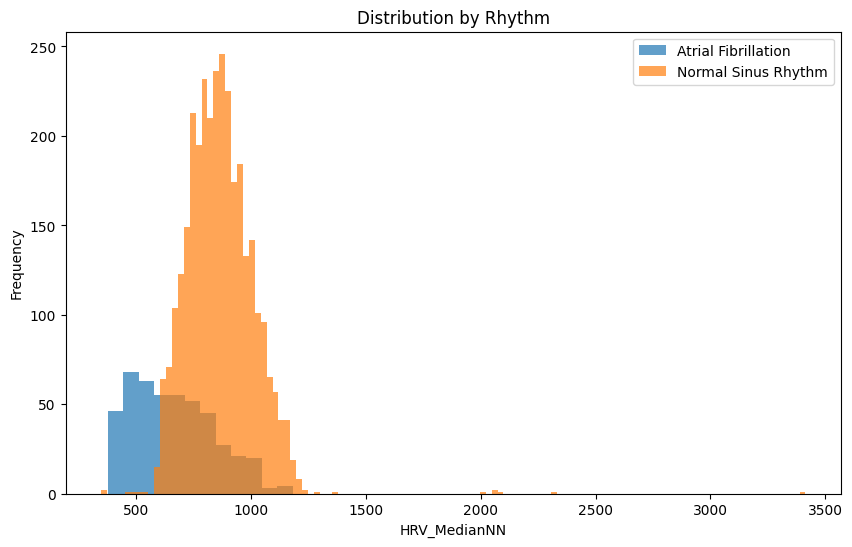

In [120]:
# Merge the HRV data with the rhythm labels
hrv_train_with_labels = pd.merge(
    hrv_train_clean, df_labels, left_on='ecg_index', right_index=True
).reset_index(drop=True)

plt.figure(figsize=(10, 6))

selectedMetric = 'HRV_MedianNN'
rhythms = hrv_train_with_labels['label'].unique()
for rhythm in rhythms:
    subset = hrv_train_with_labels[hrv_train_with_labels['label'] == rhythm]
    plt.hist(subset[selectedMetric], alpha=0.7, label=rhythm, bins='auto')

plt.xlabel(selectedMetric)
plt.ylabel('Frequency')
plt.title('Distribution by Rhythm')
plt.legend()
plt.show()

### **Outlier Detection**

In [145]:
# Function to identify outliers in the data
def identify_outliers(df, column_name, threshold=1.5):

    # Calculate Q1, Q3, and IQR
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    # Define outlier bounds
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR

    # Identify outliers
    row_indices = df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)].index.tolist()
    outlier_values = df.loc[row_indices, column_name].tolist()

    return row_indices, outlier_values, lower_bound, upper_bound

In [148]:
# Outlier detection ONLY ON TRAIN

# Merge labels with TRAIN features (cleaned hrv_train)
hrv_train_with_labels = pd.merge(
    hrv_train_clean, df_labels, left_on="ecg_index", right_index=True
)

# Outlier detection ONLY on TRAIN
train_outlier_idx, outlier_values, iqr_lower, iqr_upper = identify_outliers(
    hrv_train_with_labels,
    "HRV_MedianNN",
    threshold=1.5
)

# ecg_index as (int)
hrv_train_with_labels["ecg_index"] = hrv_train_with_labels["ecg_index"].astype(int)

print("Train outliers detected:", len(train_outlier_idx))
print("Row indices (in hrv_train_with_labels) with outliers:", train_outlier_idx)
print("Outlier HRV_MedianNN values:", outlier_values)

Train outliers detected: 44
Row indices (in hrv_train_with_labels) with outliers: [31, 79, 195, 205, 236, 313, 520, 649, 809, 836, 971, 982, 993, 1069, 1102, 1153, 1273, 1445, 1450, 1560, 1633, 1993, 2035, 2227, 2326, 2415, 2619, 2657, 2727, 2775, 2808, 2859, 2914, 2936, 2982, 3039, 3070, 3239, 3258, 3286, 3388, 3521, 3580, 3612]
Outlier HRV_MedianNN values: [386.6666666666667, 376.66666666666663, 393.33333333333337, 393.3333333333333, 395.0, 433.33333333333337, 425.0, 426.6666666666667, 416.6666666666667, 396.6666666666667, 433.33333333333337, 436.66666666666663, 430.0, 405.0, 346.6666666666667, 405.0, 393.3333333333333, 406.6666666666667, 360.0, 1300.0, 435.0, 1355.0, 413.33333333333337, 396.6666666666667, 405.0, 426.6666666666667, 413.3333333333333, 413.3333333333333, 398.33333333333337, 386.6666666666667, 420.0, 396.6666666666667, 420.0, 410.0, 400.0, 420.0, 433.33333333333337, 393.33333333333337, 421.66666666666663, 426.66666666666663, 390.0, 433.33333333333337, 420.0, 426.6666666

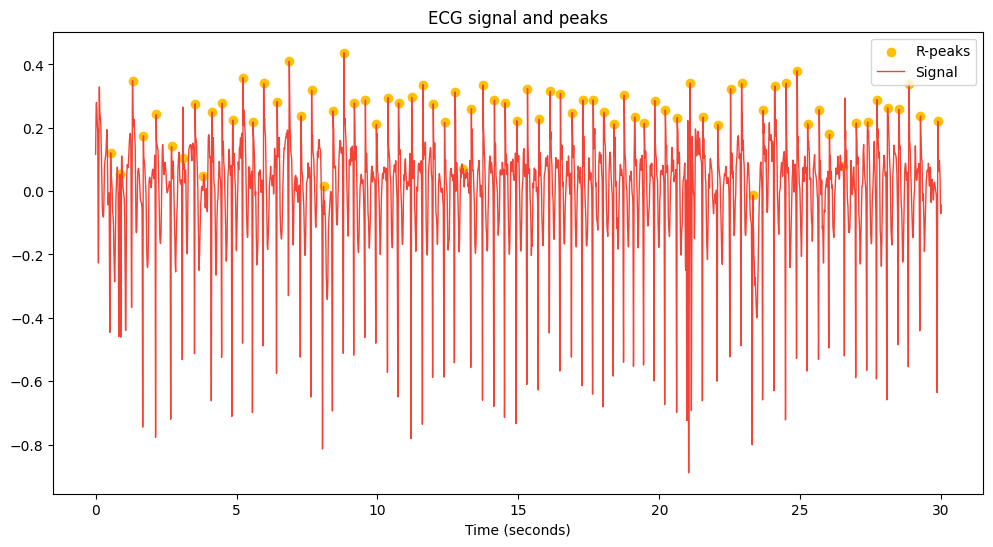

In [149]:
# Visualise one outlier ECG
example_outlier_row = train_outlier_idx[4]
ecg_index_from_outlier_row = hrv_train_with_labels.loc[example_outlier_row, "ecg_index"]

ecg_outlier = df.iloc[ecg_index_from_outlier_row].astype(float)

peaks_outlier, info_outlier = nk.ecg_peaks(
    ecg_outlier,
    sampling_rate=sampling_frequency,
    correct_artifacts=True,
    show=True
)

####**Outliers TEST set** done the same way as for TRAINING

In [124]:
# Compute test HRV
hrv_features_test = []

for i in tqdm(test_idx, desc="HRV: TEST SET"):
    ecg = df.iloc[i].astype(float)

    try:
        ecg_clean = nk.ecg_clean(ecg, sampling_rate=sampling_frequency)
        peaks, _ = nk.ecg_peaks(ecg_clean, sampling_rate=sampling_frequency)
        hrv = nk.hrv_time(peaks, sampling_rate=sampling_frequency)

        row = hrv.squeeze()
        row["ecg_index"] = i
        hrv_features_test.append(row)

    except:
        pass

hrv_test = pd.DataFrame(hrv_features_test)

# Merge labels
hrv_test_with_labels = pd.merge(
    hrv_test, df_labels, left_on="ecg_index", right_index=True
)

HRV: TEST SET: 100%|██████████| 905/905 [00:42<00:00, 21.46it/s]


In [125]:
# Same IQR bounds as on hrv_train

Q1 = hrv_train_clean["HRV_MedianNN"].quantile(0.25)
Q3 = hrv_train_clean["HRV_MedianNN"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

hrv_test_clean = hrv_test_with_labels[
    (hrv_test_with_labels["HRV_MedianNN"] >= lower_bound) &
    (hrv_test_with_labels["HRV_MedianNN"] <= upper_bound)
].copy()

**Question**: Do all detected outliers represent failed R-peak detection? What do you think is the cause of the misdetection of the R-peaks? Can you mitigate this?

Come up with at least 2 strategies to deal with outliers in your data and sketch an algorithm to implement each strategie (pseudocode)

###**Outlier Handling TRAIN**

####**A. Removal of outliers**

In [150]:
hrv_train_removed = hrv_train_with_labels.drop(train_outlier_idx).reset_index(drop=True)

print("Shape after removing outliers:", hrv_train_removed.shape)


Shape after removing outliers: (3569, 25)


####**B. Winsorising**

In [151]:
Q1 = hrv_train_with_labels["HRV_MedianNN"].quantile(0.25)
Q3 = hrv_train_with_labels["HRV_MedianNN"].quantile(0.75)
IQR = Q3 - Q1

lower_clip = Q1 - 1.5 * IQR
upper_clip = Q3 + 1.5 * IQR

hrv_train_winsor = hrv_train_with_labels.copy()
hrv_train_winsor["HRV_MedianNN_winsor"] = hrv_train_with_labels["HRV_MedianNN"].clip(
    lower=lower_clip, upper=upper_clip
)

print("Shape after winsorizing (same as original):", hrv_train_winsor.shape)



Shape after winsorizing (same as original): (3613, 26)


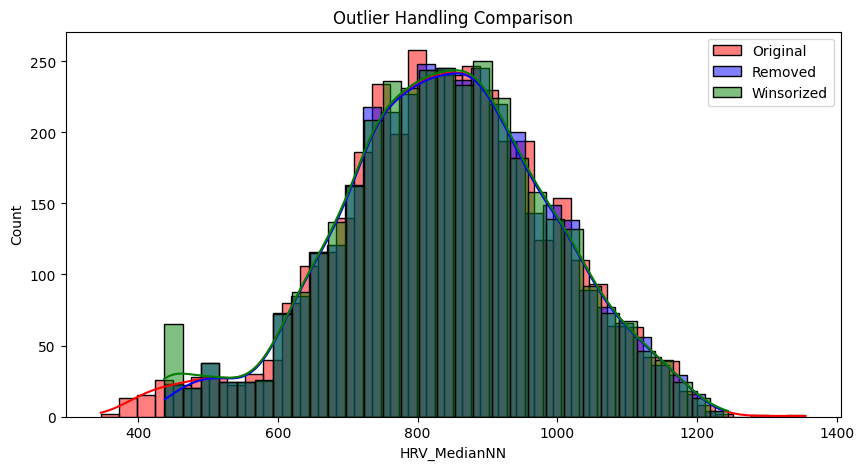

In [152]:
plt.figure(figsize=(10,5))
sns.histplot(hrv_train_with_labels["HRV_MedianNN"], kde=True, color="red", label="Original")
sns.histplot(hrv_train_removed["HRV_MedianNN"], kde=True, color="blue", label="Removed")
sns.histplot(hrv_train_winsor["HRV_MedianNN_winsor"], kde=True, color="green", label="Winsorized")

plt.legend()
plt.title("Outlier Handling Comparison")
plt.show()